In [20]:
# Download the libraries
import numpy as np
import pandas as pd
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet34
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
from google.colab import drive
import warnings
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision.transforms import RandAugment
from collections import Counter
# filter warnings
warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Set up paths
data_dir = '/content/drive/MyDrive/GoIt/DL_NLP/Datasets/HW_6'
zip_files = ['HW_6.zip']
extract_dir = os.path.join(data_dir, 'unzipped')
os.makedirs(extract_dir, exist_ok=True)

for zip_file in zip_files:
    zip_path = os.path.join(data_dir, zip_file)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Розпаковано: {zip_file}")

print("Всі архіви розпаковано.")
train_dir = os.path.join(extract_dir, 'seg_train', 'seg_train')
test_dir = os.path.join(extract_dir, 'seg_test', 'seg_test')
pred_dir = os.path.join(extract_dir,'pred_train', 'pred_train')

Розпаковано: HW_6.zip
Всі архіви розпаковано.


In [16]:
# Шляхи до папок
data_dir = train_dir
test_dir = test_dir

# Трансформації
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Завантаження датасету
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

# Розділення на train / val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Тестовий набір
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# DataLoader
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [17]:
class_names = full_dataset.classes
print('Classes:', class_names)

num_classes = len(class_names)

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 75x75

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 37x37

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 18x18
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*18*18, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

model = SimpleCNN(num_classes=6)

In [25]:
# ResNet18 з модифікацією останнього шару
resnet_model = models.resnet18(pretrained=True)

for param in resnet_model.parameters():
    param.requires_grad = False  # Заморозити всі шари

# Замінити останній повнозв'язний шар
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 6)

In [26]:
# Виберіть модель для тренування
os.environ["TORCHDYNAMO_DISABLE"] = "1"  # 🔧 Вимикає TorchDynamo

model = resnet_model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [28]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=3):

    train_loss_history = []
    val_loss_history = []

    best_accuracy = 0
    best_val_loss = float('inf')
    trigger_times = 0

    total_start_time = time.time()  # ⏱ Старт усього навчання

    for epoch in range(epochs):
        print(f"\n🧪 Epoch {epoch + 1}/{epochs}")
        epoch_start_time = time.time()


        model.train()
        train_loss = 0

        train_loader_tqdm = tqdm(train_loader, desc=f"🔁 Training Epoch {epoch+1}", leave=False)

        for images, labels in train_loader_tqdm:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_loader_tqdm.set_postfix(loss=loss.item())

        train_loss /= len(train_loader)

        # 🧪 Валідація
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        val_loader_tqdm = tqdm(val_loader, desc=f"🔍 Validating Epoch {epoch+1}", leave=False)

        with torch.no_grad():
            for images, labels in val_loader_tqdm:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                val_loader_tqdm.set_postfix(loss=loss.item())

        val_accuracy = correct / total
        val_loss /= len(val_loader)

        scheduler.step(val_loss)

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        epoch_time = time.time() - epoch_start_time
        total_elapsed = time.time() - total_start_time
        eta = (total_elapsed / (epoch + 1)) * (epochs - epoch - 1)

        print(f"📊 Epoch {epoch+1}/{epochs} | ⏱ Time: {epoch_time:.2f}s | 🏋️‍♂️ Train Loss: {train_loss:.4f} | "
              f"🧪 Val Loss: {val_loss:.4f} | ✅ Val Acc: {val_accuracy:.4f} | ⏳ ETA: {eta/60:.2f} min")

        # 💾 Збереження найкращої моделі за точністю
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_model.pth")

        # ⏹️ Early Stopping за валідаційним loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            print(f"⚠️ No improvement in val_loss. Patience: {trigger_times}/{patience}")
            if trigger_times >= patience:
                print(f"⏹️ Early stopping on epoch {epoch+1}")
                break

    total_time = time.time() - total_start_time
    print(f"\n✅ Training complete in {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

    return train_loss_history, val_loss_history

In [29]:
train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=15)


🧪 Epoch 1/15


📊 Epoch 1/15 | ⏱ Time: 78.81s | 🏋️‍♂️ Train Loss: 0.8462 | 🧪 Val Loss: 0.6089 | ✅ Val Acc: 0.7959 | ⏳ ETA: 18.39 min

🧪 Epoch 2/15


📊 Epoch 2/15 | ⏱ Time: 77.94s | 🏋️‍♂️ Train Loss: 0.5496 | 🧪 Val Loss: 0.5014 | ✅ Val Acc: 0.8244 | ⏳ ETA: 17.00 min

🧪 Epoch 3/15


📊 Epoch 3/15 | ⏱ Time: 77.59s | 🏋️‍♂️ Train Loss: 0.4963 | 🧪 Val Loss: 0.4861 | ✅ Val Acc: 0.8244 | ⏳ ETA: 15.64 min

🧪 Epoch 4/15


📊 Epoch 4/15 | ⏱ Time: 78.44s | 🏋️‍♂️ Train Loss: 0.4745 | 🧪 Val Loss: 0.4893 | ✅ Val Acc: 0.8290 | ⏳ ETA: 14.35 min
⚠️ No improvement in val_loss. Patience: 1/3

🧪 Epoch 5/15


📊 Epoch 5/15 | ⏱ Time: 78.72s | 🏋️‍♂️ Train Loss: 0.4724 | 🧪 Val Loss: 0.4779 | ✅ Val Acc: 0.8286 | ⏳ ETA: 13.06 min

🧪 Epoch 6/15


📊 Epoch 6/15 | ⏱ Time: 76.87s | 🏋️‍♂️ Train Loss: 0.4631 | 🧪 Val Loss: 0.4720 | ✅ Val Acc: 0.8336 | ⏳ ETA: 11.72 min

🧪 Epoch 7/15


📊 Epoch 7/15 | ⏱ Time: 77.73s | 🏋️‍♂️ Train Loss: 0.4457 | 🧪 Val Loss: 0.4427 | ✅ Val Acc: 0.8393 | ⏳ ETA: 10.41 min

🧪 Epoch 8/15


📊 Epoch 8/15 | ⏱ Time: 78.34s | 🏋️‍♂️ Train Loss: 0.4486 | 🧪 Val Loss: 0.4679 | ✅ Val Acc: 0.8404 | ⏳ ETA: 9.12 min
⚠️ No improvement in val_loss. Patience: 1/3

🧪 Epoch 9/15


📊 Epoch 9/15 | ⏱ Time: 78.47s | 🏋️‍♂️ Train Loss: 0.4460 | 🧪 Val Loss: 0.4550 | ✅ Val Acc: 0.8479 | ⏳ ETA: 7.82 min
⚠️ No improvement in val_loss. Patience: 2/3

🧪 Epoch 10/15


📊 Epoch 10/15 | ⏱ Time: 78.22s | 🏋️‍♂️ Train Loss: 0.4354 | 🧪 Val Loss: 0.4489 | ✅ Val Acc: 0.8425 | ⏳ ETA: 6.52 min
⚠️ No improvement in val_loss. Patience: 3/3
⏹️ Early stopping on epoch 10

✅ Training complete in 781.91 seconds (13.03 minutes)


              precision    recall  f1-score   support

   buildings       0.88      0.88      0.88       437
      forest       0.98      0.97      0.98       474
     glacier       0.84      0.78      0.81       553
    mountain       0.81      0.78      0.80       525
         sea       0.85      0.94      0.89       510
      street       0.88      0.92      0.90       501

    accuracy                           0.87      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.87      0.87      0.87      3000



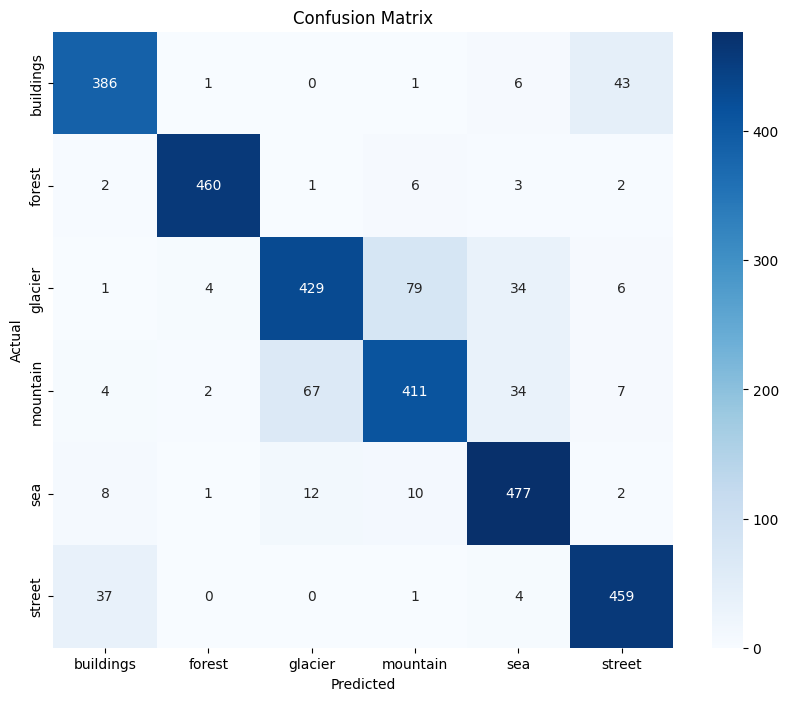

In [30]:
# Завантаження найкращої моделі
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Звіт класифікації
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Матриця помилок
conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

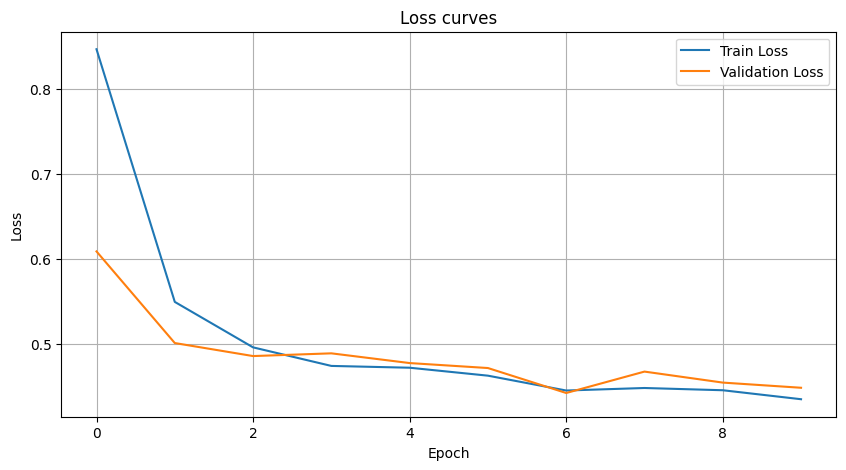

In [31]:
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curves')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [33]:
test_accuracy = evaluate_model(model, test_loader)
print(f"🎯 Test Accuracy: {test_accuracy:.4f}")

🎯 Test Accuracy: 0.8740


**Загальні результати:**
  
  * Accuracy: 87%

  * F1-score macro avg: 88%

  * Найкращі класи: forest, sea, street

  * Слабші класи: glacier, mountain

**Чому модель не досягла 100% точності?**

* Візуальна схожість між класами: деякі категорії (наприклад, mountain, glacier, sea) можуть мати подібні ознаки: блакитне небо, сніг, скелі. Це ускладнює навчання навіть для людини.

* Імовірна нерівномірність в наборі даних (кількість прикладів, різноманітність): якщо в glacier або mountain менше прикладів або менше різноманіття (кутів, освітлення), модель переобучається на загальні ознаки.

* Можливе перенавчання: висока точність на forest або street, але гірша — на складних класах, свідчить про overfitting на певні патерни.

* Неідеальна генералізація: можливо, використовувалась обмежена кількість аугментацій, які не охоплюють всі можливі варіації зображень.

**Критична оцінка архітектури моделіЖ**

 + Чому обрана саме ця структура (ResNet18 / CNN):
ResNet18 має доведену ефективність у задачах класифікації природних зображень.

Вона не надто глибока, тому:
+ Добре підходить для помірного об’єму даних.

+ Швидко навчається і не потребує великих ресурсів.

Коли використовувалась власна CNN, вона, була легка і добре контрольована по структурі.


**Потенційні недоліки:**

+ ResNet18 може бути занадто простою для складних меж між класами.

+ Коли застосовувався transfer learning без fine-tuning, модель не адаптувалася до специфіки датасету.

+ Власна CNN надто проста (1–2 блоки Conv+Pool), не захоплює достатньо глибоких ознак, потрібних для точного розрізнення glacier від sea.

**Шляхи покращення моделіЖ**

Конкретні ідеї для оптимізації:
+ Аугментації: збільшити варіативність для слабких класів (glacier, mountain) — додати:

+ Class weights у втраті: використовувати CrossEntropyLoss(weight=...) із більшими вагами для glacier, mountain.

+ Scheduler: щоб уникнути перенавчання, що вже частково реалізовано.

**Альтернативні підходи:**
+ Більш потужна архітектура:

+ ResNet50, EfficientNetB0 або ConvNeXtTiny — здатні захопити складніші просторові патерни.

+ Ensemble моделей — об’єднання результатів кількох CNN/ResNet дає зазвичай 2–5% приросту точності.

+ Attention механізми (CBAM, SE-блоки) — допомагають фокусуватись на ключових ділянках зображення.

**Висновок:**
Модель показала стабільні та сильні результати, проте має слабкі місця в складних класах. Архітектура ResNet18 є доцільною, але для вищої точності варто використовувати глибші або більш адаптовані моделі, розширені аугментації, і враховувати класовий дисбаланс.